In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import *
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from catboost import Pool, CatBoostRegressor

Carico Dataset e visualizzo colonne

In [2]:
df = pd.read_csv('Crimes_-_2001_to_Present.csv')


In [14]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

Dopo aver visualizzato la heatmap, faccio feature engineering

In [15]:
df['Description'] = df['Primary Type'] + '; ' + df['Description']


In [24]:
df['Block'] = df['Block'].str[:3]

cols2drop = ['Case Number', 'Primary Type', 'Date', 'IUCR', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 
             'Updated On', 'Latitude', 'Longitude', 'Location']
df1 = df.drop(cols2drop, axis=1)



c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:

for col in ['Description', 'Location Description','Block']:
    df1[col] = df1[col].fillna('None')
    encoder = LabelEncoder()
    df1[col] = encoder.fit_transform(df1[[col]])
    

c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
df1.head()
df1.describe()

,ID,Block,Description,Location Description,Year
count,7.842937e+06,7.842937e+06,7.842937e+06,7.842937e+06,7.842937e+06
mean,7.071242e+06,4.054249e+01,2.764802e+02,1.408834e+02,2.010041e+03
std,3.528350e+06,3.034694e+01,1.945395e+02,6.292754e+01,6.336775e+00
min,6.340000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.001000e+03
25%,3.814349e+06,1.400000e+01,9.800000e+01,1.050000e+02,2.005000e+03
50%,7.072857e+06,3.600000e+01,2.240000e+02,1.610000e+02,2.009000e+03
75%,1.020682e+07,6.200000e+01,4.960000e+02,1.900000e+02,2.015000e+03
max,1.314245e+07,1.430000e+02,5.900000e+02,2.170000e+02,2.023000e+03


In [33]:
grouped_data = df1.groupby(['Block', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Year']).size().reset_index(name='Count')
ultimi_3 = df['Year'].nlargest(3)


In [ ]:

train = grouped_data[grouped_data['Year'] < ultimi_3.min()]
test = grouped_data[grouped_data['Year'] >= ultimi_3.min()]

In [34]:
Y_train = train['Count']
X_train = train.drop(['Count'], axis=1)
Y_test = test['Count']
X_test = test.drop(['Count'], axis=1)

In [35]:
def find_best_model(X_train, y_train, regressors):
    best_regressor_name = None
    best_regressor = None
    best_score = -float('inf')
    best_params = None

    for name, regressor, param_grid in regressors:
        pipeline = Pipeline([
            (name, regressor)
        ])

        grid_search = GridSearchCV(pipeline, param_grid, cv=2, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        print(f"{name} - Best R-squared: {grid_search.best_score_}")
        print(f"Best parameters: {grid_search.best_params_}")
        
        if grid_search.best_score_ > best_score:
            best_regressor_name = name
            best_regressor = regressor
            best_score = grid_search.best_score_
            best_params = grid_search.best_params_

    return best_regressor_name, best_regressor, best_score, best_params
regressors = [
     ('KNN', KNeighborsRegressor(), 
     {'KNN__n_neighbors': [3, 5, 7, 9, 11], 'KNN__weights': ['uniform', 'distance']}),
     
    ('Decision Tree', DecisionTreeRegressor(), 
     {'Decision Tree__max_depth': [None, 5, 10, 15, 20], 'Decision Tree__min_samples_split': [2, 5, 10]}),
     
     
    ('XGB', XGBRegressor(), 
     {'XGB__n_estimators': [50, 100, 200], 'XGB__learning_rate': [ 0.1, 1], 'XGB__max_depth': [3, 5]}),

]

In [36]:
best_regressor_name, best_regressor, best_score, best_params = find_best_model(X_train, Y_train, regressors)
print(f"Best regressor: {best_regressor} with accuracy {best_score}")
print(f"Best parameters: {best_params}")

KNN - Best R-squared: 0.247759434051381
Best parameters: {'KNN__n_neighbors': 5, 'KNN__weights': 'distance'}
Decision Tree - Best R-squared: 0.38731917957998013
Best parameters: {'Decision Tree__max_depth': 20, 'Decision Tree__min_samples_split': 10}
XGB - Best R-squared: 0.2533288295333201
Best parameters: {'XGB__learning_rate': 0.1, 'XGB__max_depth': 5, 'XGB__n_estimators': 200}
Best regressor: DecisionTreeRegressor() with accuracy 0.38731917957998013
Best parameters: {'Decision Tree__max_depth': 20, 'Decision Tree__min_samples_split': 10}


In [37]:
best_params_stripped = {param.split('__')[1]: value for param, value in best_params.items() if best_regressor_name in param}

best_regressor.set_params(**best_params_stripped)

best_pipeline = Pipeline([
    (best_regressor_name, best_regressor)
])

best_pipeline.fit(X_train, Y_train)
Y_pred = best_pipeline.predict(X_test)

# Evaluation metrics for regression
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 32.477191099934934
Mean Absolute Error (MAE): 1.8790248894523938
R-squared (R2): 0.20708744808588042


In [38]:

train_pool = Pool(X_train, 
                  Y_train, 
                  cat_features=list(X_train.columns))
test_pool = Pool(X_test,
                 Y_test,
                 cat_features=list(X_train.columns))


In [39]:

model = CatBoostRegressor(loss_function='RMSE')

In [40]:
model.fit(train_pool)
pred = model.predict(X_test)


Learning rate set to 0.136669
0:	learn: 10.5775295	total: 1.78s	remaining: 29m 41s
1:	learn: 10.2233903	total: 2.41s	remaining: 20m 3s
2:	learn: 9.9470959	total: 3.32s	remaining: 18m 24s
3:	learn: 9.7162259	total: 3.86s	remaining: 16m 1s
4:	learn: 9.4913247	total: 4.54s	remaining: 15m 3s
5:	learn: 9.3505035	total: 5.49s	remaining: 15m 10s
6:	learn: 9.2190152	total: 6.1s	remaining: 14m 25s
7:	learn: 9.0425013	total: 6.79s	remaining: 14m 1s
8:	learn: 8.8378835	total: 7.61s	remaining: 13m 58s
9:	learn: 8.7386349	total: 8.05s	remaining: 13m 17s
10:	learn: 8.5665115	total: 8.69s	remaining: 13m 1s
11:	learn: 8.4356420	total: 9.63s	remaining: 13m 12s
12:	learn: 8.3746736	total: 10.1s	remaining: 12m 44s
13:	learn: 8.2731630	total: 10.5s	remaining: 12m 17s
14:	learn: 8.1577901	total: 11s	remaining: 12m
15:	learn: 8.0997436	total: 11.7s	remaining: 12m
16:	learn: 8.0351041	total: 12.3s	remaining: 11m 52s
17:	learn: 7.9948258	total: 12.7s	remaining: 11m 35s
18:	learn: 7.9485644	total: 13.3s	remain

In [41]:

rmse = (np.sqrt(mean_squared_error(Y_test, pred)))
r2 = r2_score(Y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 9.59
R2: -1.24


Troppi tipi di crimine potrebbero influenzare l'algoritmo

In [42]:


cols2drop = ['Case Number','Description', 'Date', 'IUCR', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 
             'Updated On', 'Latitude', 'Longitude', 'Location']
df2 = df.drop(cols2drop, axis=1)
for col in ['Primary Type','Location Description','Block']:
    df2[col] = df2[col].fillna('None')
    encoder = LabelEncoder()
    df2[col] = encoder.fit_transform(df2[[col]])

    

c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
df2.head()

,ID,Block,Primary Type,Location Description,Arrest,Domestic,Year
0,11646166,82,34,161,False,True,2018
1,11645836,55,9,139,False,False,2016
2,11449702,9,19,190,True,False,2018
3,11643334,56,6,190,False,False,2018
4,11645527,69,9,141,False,False,2015


In [44]:
grouped_data_1 = df2.groupby(['Block', 'Primary Type', 'Arrest', 'Domestic', 'Year']).size().reset_index(name='Count')


train_1 = grouped_data_1[grouped_data_1['Year'] < ultimi_3.min()]
test_1 = grouped_data_1[grouped_data_1['Year'] >= ultimi_3.min()]

In [45]:
Y1_train = train_1['Count']
X1_train = train_1.drop(['Count'], axis=1)
Y1_test = test_1['Count']
X1_test = test_1.drop(['Count'], axis=1)

In [46]:
cat_cols_idx1 = list(X1_train.columns)

train_pool = Pool(X1_train, 
                  Y1_train, 
                  cat_features=cat_cols_idx1)
test_pool = Pool(X1_test,
                 Y1_test,
                 cat_features=cat_cols_idx1)
model_1 = CatBoostRegressor(loss_function='RMSE')
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[6, 10],
    'l2_leaf_reg': [7, 9]
}
grid_search_results = model_1.grid_search(grid, train_pool, shuffle=False, verbose=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 140.6717636	test: 24.3807216	best: 24.3807216 (0)	total: 149ms	remaining: 2m 28s
1:	learn: 138.2158228	test: 22.3196464	best: 22.3196464 (1)	total: 255ms	remaining: 2m 7s
2:	learn: 135.9032875	test: 21.5895509	best: 21.5895509 (2)	total: 338ms	remaining: 1m 52s
3:	learn: 133.6372879	test: 20.5127347	best: 20.5127347 (3)	total: 469ms	remaining: 1m 56s
4:	learn: 131.4143086	test: 20.1456852	best: 20.1456852 (4)	total: 541ms	remaining: 1m 47s
5:	learn: 129.3502959	test: 20.1184882	best: 20.1184882 (5)	total: 600ms	remaining: 1m 39s
6:	learn: 127.3450027	test: 20.4768066	best: 20.1184882 (5)	total: 690ms	remaining: 1m 37s
7:	learn: 125.3701708	test: 21.4763755	best: 20.1184882 (5)	total: 752ms	remaining: 1m 33s
8:	learn: 123.4920421	test: 22.3342888	best: 20.1184882 (5)	total: 825ms	remaining: 1m 30s
9:	learn: 121.7099506	test: 23.2058827	best: 20.1184882 (5)	total: 906ms	remaining: 1m 29s
10:	learn: 120.4239555	test: 24.3300666	best: 20.1184882 (5)	total: 998ms	remaining: 1m 29s

In [47]:

grid_search_results['params']
best_model_1 = CatBoostRegressor(loss_function='RMSE', l2_leaf_reg = grid_search_results['params']['l2_leaf_reg'], 
                learning_rate = grid_search_results['params']['learning_rate'], depth = grid_search_results['params']['depth'])
best_model_1.fit(train_pool)


0:	learn: 117.1740015	total: 355ms	remaining: 5m 54s
1:	learn: 114.5071790	total: 581ms	remaining: 4m 50s
2:	learn: 111.9368140	total: 736ms	remaining: 4m 4s
3:	learn: 109.4005146	total: 869ms	remaining: 3m 36s
4:	learn: 106.8625143	total: 1.06s	remaining: 3m 31s
5:	learn: 104.3621345	total: 1.25s	remaining: 3m 27s
6:	learn: 102.0399866	total: 1.49s	remaining: 3m 31s
7:	learn: 99.7266572	total: 1.66s	remaining: 3m 25s
8:	learn: 97.5076939	total: 1.81s	remaining: 3m 19s
9:	learn: 95.3315337	total: 2.03s	remaining: 3m 21s
10:	learn: 93.3660986	total: 2.21s	remaining: 3m 18s
11:	learn: 91.3769477	total: 2.45s	remaining: 3m 21s
12:	learn: 89.4503698	total: 2.67s	remaining: 3m 22s
13:	learn: 87.5616937	total: 2.81s	remaining: 3m 17s
14:	learn: 85.7520388	total: 2.94s	remaining: 3m 12s
15:	learn: 84.0733873	total: 3.08s	remaining: 3m 9s
16:	learn: 82.3642009	total: 3.28s	remaining: 3m 9s
17:	learn: 80.7315796	total: 3.42s	remaining: 3m 6s
18:	learn: 79.1556927	total: 3.55s	remaining: 3m 3s
1

In [48]:
pred_1 = best_model_1.predict(X1_test)

pred_1[pred_1<0.5] = 0

rmse_1 = (np.sqrt(mean_squared_error(Y1_test, pred_1)))
r2_1 = r2_score(Y1_test, pred_1)
mae_1 = np.mean(np.abs(Y1_test-pred_1))
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse_1))
print('R2: {:.2f}'.format(r2_1))
print('MAE: {:.2f}'.format(mae_1))



Testing performance
RMSE: 37.85
R2: 0.43
MAE: 17.22


In [49]:
max(Y1_train)

3706

In [50]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [51]:
shap.initjs()

In [52]:

explainer = shap.Explainer(best_model_1)
shap_values = explainer(X1_train)


In [53]:
shap.plots.force(shap_values[0:1000,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


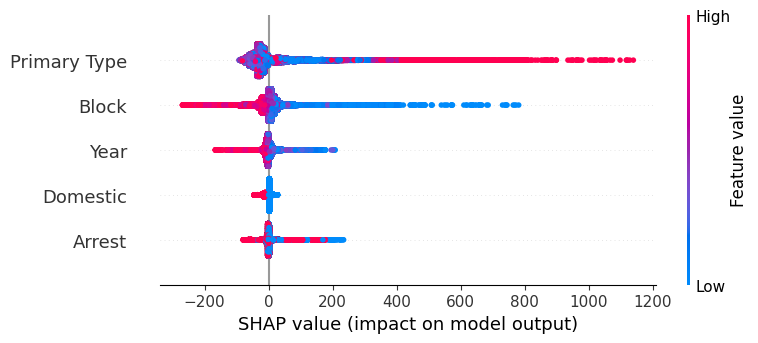

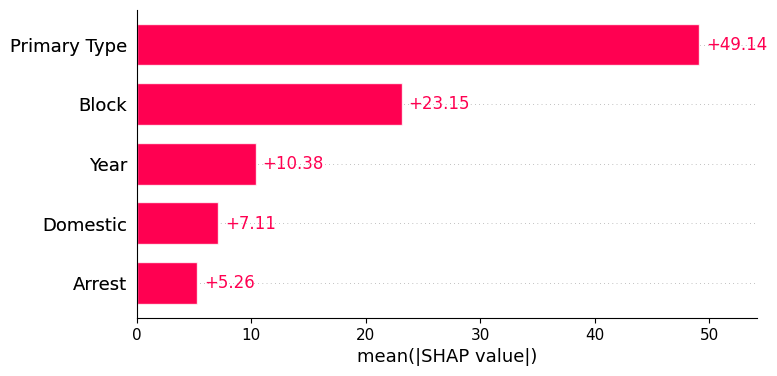

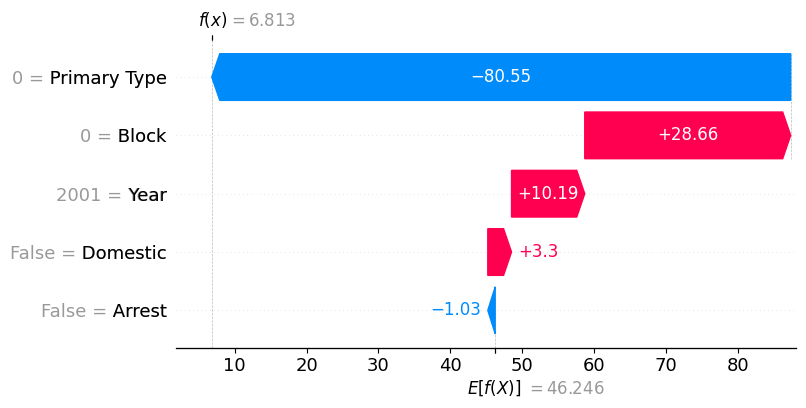

In [54]:
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)
shap.plots.waterfall(shap_values[0])

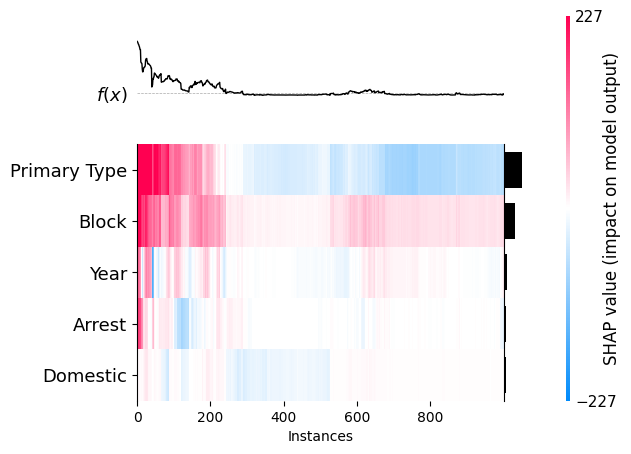

In [55]:
shap.plots.heatmap(shap_values[:1000])

In [8]:
import holidays
import datetime

In [ ]:
time_obj = datetime.strptime(time_str, "%I:%M:%S %p")

In [14]:
df['Hours'] = df['Date'].str[-11:]

In [17]:
df['Hours'] = pd.to_datetime(df['Hours'], format= '%I:%M:%S %p')

In [21]:
bins = [0, 6, 12, 18, 24] 
labels = ['Night', 'Morning', 'Afternoon', 'Evening']  
df['Hours'] = pd.cut(df['Hours'].dt.hour, bins=bins, labels=labels, right=False)

In [22]:
df['Hours']

0              Night
1              Night
2          Afternoon
3          Afternoon
4            Morning
             ...    
7842932      Evening
7842933        Night
7842934    Afternoon
7842935    Afternoon
7842936    Afternoon
Name: Hours, Length: 7842937, dtype: category
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

In [24]:
for col in ['Hours']:
    df[col] = df[col]
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[[col]])

c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
us_holidays = holidays.US(years=list(df['Year'].unique()), observed=True)

In [32]:
df['Holiday'] = df['Date'].str[:10]
df['Holiday'] = pd.to_datetime(df['Holiday'], format= 'mixed')

In [35]:
check = list()

In [36]:
for date in df['Holiday']:
    if date in us_holidays:
         check.append(1)
    else:
        check.append(0)

In [41]:
df['Holi'] = check

In [42]:
df['Holi']

0          0
1          0
2          0
3          0
4          0
          ..
7842932    0
7842933    0
7842934    0
7842935    0
7842936    0
Name: Holi, Length: 7842937, dtype: int64

In [65]:
df['Block'] = df.Block.str[:3]

In [78]:
grouped_data_2 = df.groupby(['Block', 'Year','Hours','Holi']).size().reset_index(name='Count')

for col in ['Block','Holi']:
    grouped_data_2[col] = grouped_data_2[col]
    encoder = LabelEncoder()
    grouped_data_2[col] = encoder.fit_transform(grouped_data_2[[col]])
ultimi_3 = df['Year'].nlargest(3)

train_2 = grouped_data_2[grouped_data_2['Year'] < ultimi_3.min()]
test_2 = grouped_data_2[grouped_data_2['Year'] >= ultimi_3.min()]

c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\loren\OneDrive - Politecnico di Milano\Blocchi appunti\ACADEMY\.venv\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
Y2_train = train_2['Count']
X2_train = train_2.drop(['Count'], axis=1)
Y2_test = test_2['Count']
X2_test = test_2.drop(['Count'], axis=1)

In [80]:
cat_cols_idX2 = list(X2_train.columns)

train2_pool = Pool(X2_train, 
                  Y2_train, 
                  cat_features=cat_cols_idX2)
test2_pool = Pool(X2_test,
                 Y2_test,
                 cat_features=cat_cols_idX2)


In [ ]:

model_2 = CatBoostRegressor(loss_function='RMSE')
grid2 = {
    'learning_rate': [0.03, 0.1],
    'depth':[6, 10],
    'l2_leaf_reg': [7, 9]
}
grid_search_results_2 = model_2.grid_search(grid2, train2_pool, shuffle=False, verbose=3, plot=True)

Uso gli stessi valori dei modelli precedenti

In [81]:

best_model_2 = CatBoostRegressor(loss_function='RMSE', l2_leaf_reg = 9, 
                learning_rate = 0.03, depth = 10, iterations=500)
best_model_2.fit(train2_pool)

0:	learn: 486.6937596	total: 72ms	remaining: 35.9s
1:	learn: 477.9557253	total: 136ms	remaining: 33.8s
2:	learn: 469.2078470	total: 203ms	remaining: 33.6s
3:	learn: 460.8235302	total: 266ms	remaining: 33s
4:	learn: 453.0296178	total: 335ms	remaining: 33.2s
5:	learn: 445.3284409	total: 401ms	remaining: 33s
6:	learn: 437.6269641	total: 463ms	remaining: 32.6s
7:	learn: 430.0949419	total: 531ms	remaining: 32.6s
8:	learn: 422.8742253	total: 608ms	remaining: 33.2s
9:	learn: 415.9338766	total: 679ms	remaining: 33.3s
10:	learn: 409.3873390	total: 752ms	remaining: 33.4s
11:	learn: 403.5908362	total: 787ms	remaining: 32s
12:	learn: 397.5981683	total: 834ms	remaining: 31.2s
13:	learn: 391.6575460	total: 905ms	remaining: 31.4s
14:	learn: 386.1119379	total: 950ms	remaining: 30.7s
15:	learn: 380.8438781	total: 1.01s	remaining: 30.5s
16:	learn: 375.4801533	total: 1.05s	remaining: 30s
17:	learn: 370.3047034	total: 1.12s	remaining: 30s
18:	learn: 365.4836782	total: 1.18s	remaining: 29.9s
19:	learn: 360

In [82]:
pred_2 = best_model_2.predict(X2_test)

pred_2[pred_2<0.5] = 0

rmse_2 = (np.sqrt(mean_squared_error(Y2_test, pred_2)))
r2_2 = r2_score(Y2_test, pred_2)
mae_2 = np.mean(np.abs(Y2_test-pred_2))
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse_2))
print('R2: {:.2f}'.format(r2_2))
print('MAE: {:.2f}'.format(mae_2))


Testing performance
RMSE: 98.51
R2: 0.69
MAE: 79.13


In [88]:
import shap
shap.initjs()
explainer2 = shap.Explainer(best_model_2)
shap_values2 = explainer2(X2_train)


In [89]:
shap.plots.force(shap_values2[0:1000])

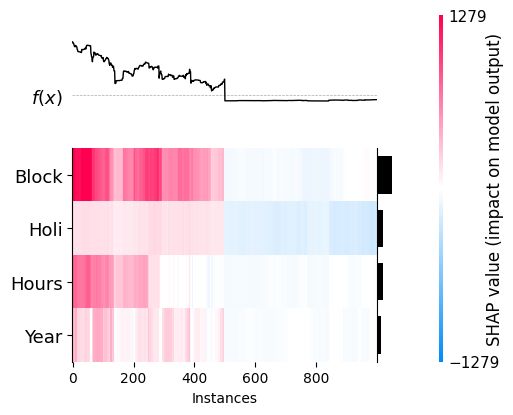

In [90]:
shap.plots.heatmap(shap_values2[0:1000])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


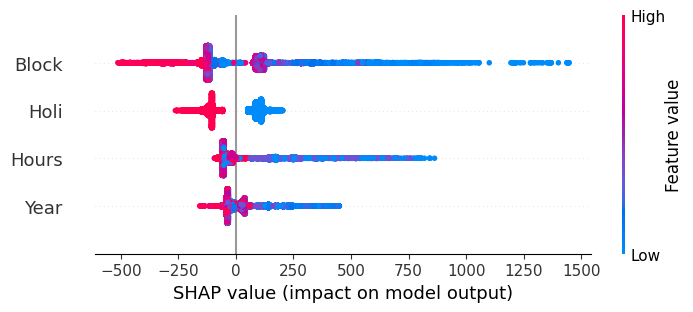

In [96]:
shap.plots.beeswarm(shap_values2)


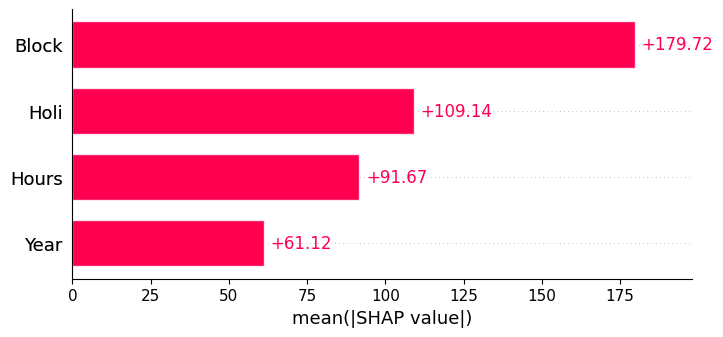

In [92]:

shap.plots.bar(shap_values2)


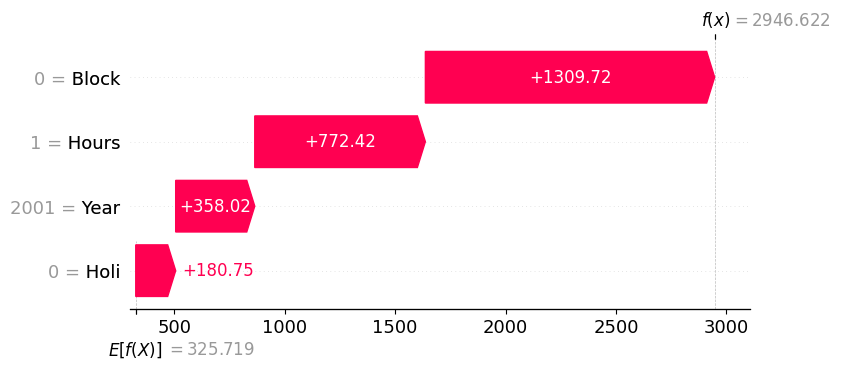

In [95]:

shap.plots.waterfall(shap_values2[2])